In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


### Load the data

In [2]:
''' load the data '''
# the dataset is in one of the ancillary tensorflow libraries
# some more information can be found here: https://www.tensorflow.org/datasets/catalog/imdb_reviews

# the dataset class is very useful to understand and an important tool for dealing with
# larger datasets, but this is outside of what we're looking at now.

# this downloads the dataset into this session, and will be removed when this notebook is restarted
train_dataset, test_dataset = tfds.load("IMDBReviews",
                                        batch_size = 16,
                                        split = ['train', 'test'])



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKVAMTC/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKVAMTC/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKVAMTC/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
''' visualize a sample '''
# can use next and iter to pull a sample for visualization
# train dataset can only (?) be accessed iteratively, but we can fake it with these functions
vis_sample = next(iter(train_dataset))
print(vis_sample)

# this is a dictionary with 2 keys: 'label' and 'text'
# the labels are 0 or 1 indicating bad and good movie review respectively.

{'label': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0])>, 'text': <tf.Tensor: shape=(16,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things includ

In [ ]:
# there is a difference between bytes and strings.
# this can be converted to a string with .decode()
print(vis_sample['text'][14].numpy(),'\n')
print(vis_sample['text'][14].numpy().decode('utf-8'))

# notice the difference for apostraphes ( Bunuel\'s vs Bunuel's )

b'Hilarious, evocative, confusing, brilliant film. Reminds me of Bunuel\'s L\'Age D\'Or or Jodorowsky\'s Holy Mountain-- lots of strange characters mucking about and looking for..... what is it? I laughed almost the whole way through, all the while keeping a peripheral eye on the bewildered and occasionally horrified reactions of the audience that surrounded me in the theatre. Entertaining through and through, from the beginning to the guts and poisoned entrails all the way to the end, if it was an end. I only wish i could remember every detail. It haunts me sometimes.<br /><br />Honestly, though, i have only the most positive recollections of this film. As it doesn\'t seem to be available to take home and watch, i suppose i\'ll have to wait a few more years until Crispin Glover comes my way again with his Big Slide Show (and subsequent "What is it?" screening)... I saw this film in Atlanta almost directly after being involved in a rather devastating car crash, so i was slightly dazed 

### Preprocessing

Define a custom standardization function. It does some cleanup of html elements, converts everything to lower case and removes punctuation

In [4]:
''' function to remove punctuation and html breaks '''
def custom_standardization(input_data): # keras text from scratch
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ") # this removes <br />
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", "") # this removes punctuations

# quick check of before and after standardization
print('before:', vis_sample['text'][7].numpy().decode(),'\n')
print('after: ', custom_standardization(vis_sample['text'])[7].numpy().decode()) # processed data.

before: The film is based on a genuine 1950s novel.<br /><br />Journalist Colin McInnes wrote a set of three "London novels": "Absolute Beginners", "City of Spades" and "Mr Love and Justice". I have read all three. The first two are excellent. The last, perhaps an experiment that did not come off. But McInnes's work is highly acclaimed; and rightly so. This musical is the novelist's ultimate nightmare - to see the fruits of one's mind being turned into a glitzy, badly-acted, soporific one-dimensional apology of a film that says it captures the spirit of 1950s London, and does nothing of the sort.<br /><br />Thank goodness Colin McInnes wasn't alive to witness it. 

after:  the film is based on a genuine 1950s novel  journalist colin mcinnes wrote a set of three london novels absolute beginners city of spades and mr love and justice i have read all three the first two are excellent the last perhaps an experiment that did not come off but mcinness work is highly acclaimed and rightly so 

In [5]:
# Extract all the training data strings into a simple list
# each element is a review

# initialize a list
text_ds = list()
# fill with the training dataset
for batch in tqdm(train_dataset):
    for i in batch['text']:
      text_ds.append(i.numpy())
# check the length of this dataset
len(text_ds)

100%|██████████| 1563/1563 [00:20<00:00, 76.28it/s] 


25000

In [6]:
''' pull the labels together '''
# these will be the targets for training

label_ds = list()
for batch in tqdm(train_dataset):
    for i in batch['label']:
      label_ds.append(i.numpy())
label_ds = np.array(label_ds)
len(label_ds)

100%|██████████| 1563/1563 [00:20<00:00, 76.29it/s] 


25000

### Initialize language layers

We need to initialize the TokenVectorization layer with some hyperparameters

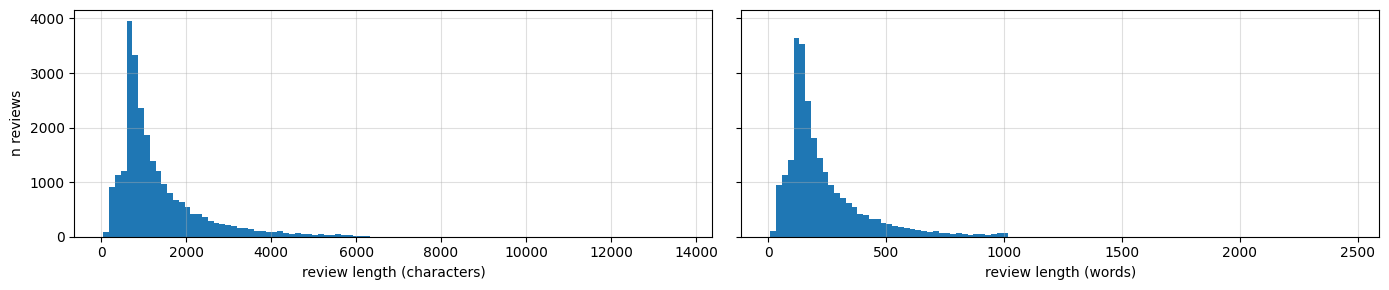

In [7]:
fig,ax = plt.subplots(1,2,figsize=(14,3), sharey=True)
ax[0].hist([len(x) for x in text_ds],bins=100) # this is a list comprehension (worth learning, but not completely necessary)
ax[0].set_xlabel('review length (characters)')
ax[0].set_ylabel('n reviews')
ax[0].grid(alpha=0.4)

ax[1].hist([len(x.decode().split(' ')) for x in text_ds],bins=100)
ax[1].set_xlabel('review length (words)')
ax[1].grid(alpha=0.4)
plt.tight_layout()
# most reviews are < 500 words (and we can probably get the gist of the review )

In [8]:
''' find the number of unique words '''
# not just the number of words, but also look at how additional reviews contribute to new words
# (this is a wildly inefficient implementation)

seen_words = set()
new_words = list()

for x in tqdm(text_ds):
  new_set = set(custom_standardization(x).numpy().decode().split(' '))
  a = len(seen_words)
  seen_words = seen_words.union(new_set)
  new_words.append(len(seen_words) - a)


100%|██████████| 25000/25000 [02:43<00:00, 152.62it/s]


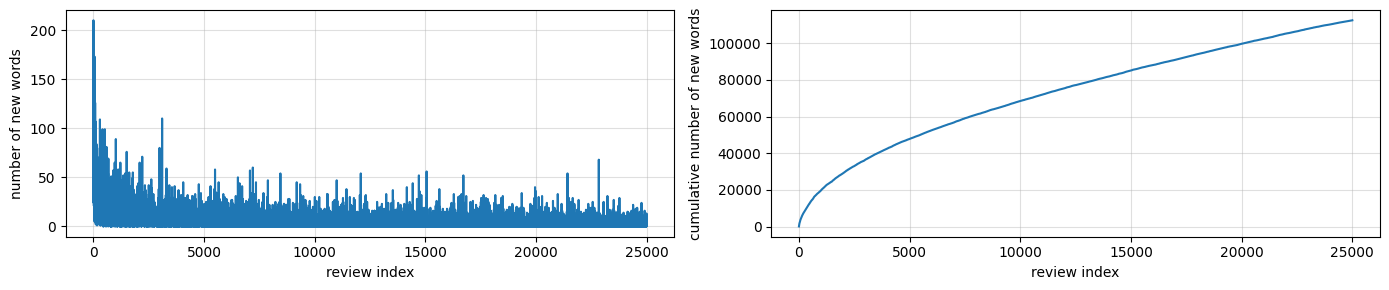

In [ ]:
# visualize how new words are found in reviews
# this is used to help determine how large a vocabulary we should use
fig,ax = plt.subplots(1,2,figsize=(14,3))
ax[0].plot(new_words)
ax[0].set_xlabel('review index')
ax[0].set_ylabel('number of new words')
ax[0].grid(alpha=0.4)

ax[1].plot(np.cumsum(new_words))
ax[1].set_xlabel('review index')
ax[1].set_ylabel('cumulative number of new words')
ax[1].grid(alpha=0.4)
plt.tight_layout()


In [9]:
''' implement the vectorization layer '''

# layer constants
vocab_length = 20000 # <- how many different words to have in the vocabulary
embedding_dim = 64
sequence_length = 500 # <- review length (clip or pad as needed)

vectorize_layer = tf.keras.layers.TextVectorization(
        standardize = custom_standardization, # alternatively: 'lower_and_strip_punctuation'
        max_tokens = vocab_length,
        output_mode = "int",
        output_sequence_length = sequence_length )


In [10]:
''' adapt the layer to the training dataset '''
# this figures out which words to keep and which to discard
vectorize_layer.adapt(text_ds)

# converting words to integers
# (this will be rolled into the model, but we can investigate things here first)
vectorized_data = vectorize_layer(text_ds)

vectorized_data.shape

TensorShape([25000, 500])

In [14]:
''' look into vocabulary '''
print('top 10 words:',vectorize_layer.get_vocabulary()[:10]) # look at the top 10 words

# look up a specific word
#word_query = 'amazeballs'
#print(word_query,':', vectorize_layer.get_vocabulary().index(word_query))
#word_query = 'sandcastle'
#print(word_query,':', vectorize_layer.get_vocabulary().index(word_query))
word_query = 'evil'
print(word_query,':', vectorize_layer.get_vocabulary().index(word_query))

top 10 words: ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
evil : 433


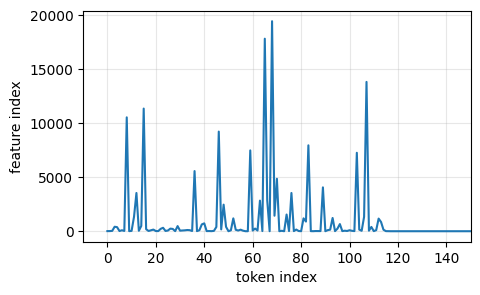

In [15]:
''' look at a vectorized review '''

# plot it
plt.figure(figsize=(5,3))
plt.plot(vectorized_data[0])
plt.xlabel('token index')
plt.ylabel('feature index')
plt.xlim(-10, 150)
plt.grid(alpha=0.3);


<ipython-input-123-ffbca9d778c2>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(vectorized_data[:600]))


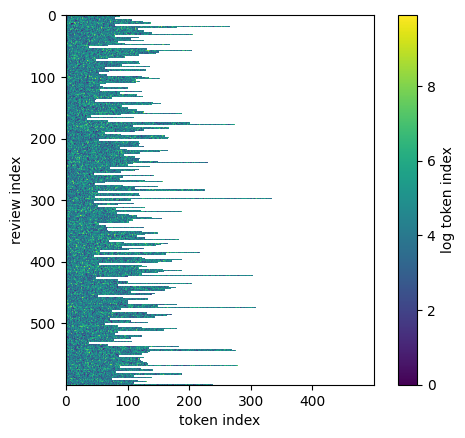

In [ ]:
# visualize first 600 reviews (kind of)
plt.imshow(np.log(vectorized_data[:600]))
plt.xlabel('token index')
plt.ylabel('review index')
plt.colorbar(label='log token index');

100%|██████████| 25000/25000 [00:00<00:00, 181110.91it/s]


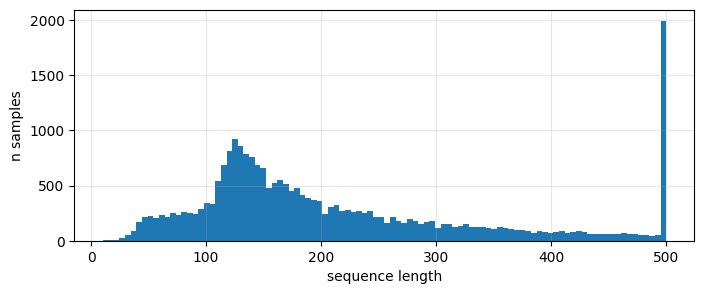

In [16]:
''' find the sequence length distribution '''
# what is the effect of clipping reviews to 500 words

seq_length = list()
for sample in tqdm(np.array(vectorized_data)):
    # ignore padding (identified as tokens with value == 0)
    mask = (sample > 0)
    seq_length.append(mask.sum())

# vis sequence length distribution
plt.figure(figsize=(8,3))
plt.hist(seq_length, bins=100)
plt.xlabel('sequence length')
plt.ylabel('n samples')
plt.grid(alpha=0.3);

#### tangental visualization

In [ ]:
''' token usage ''' # zipf it

token_dict = {}
for sample in tqdm(np.array(vectorized_data)):
    for token in sample:
      if token in token_dict.keys():
        token_dict[token] += 1
      else:
        token_dict[token] = 1
del token_dict[0]

100%|██████████| 25000/25000 [00:07<00:00, 3475.82it/s]


In [ ]:
''' how many times does a word get used? '''
word_query = 'gorgeous'
print(f'"{word_query}" used:', token_dict[vectorize_layer.get_vocabulary().index(word_query)])


"gorgeous" used: 347


Text(0.5, 1.0, 'zipf !')

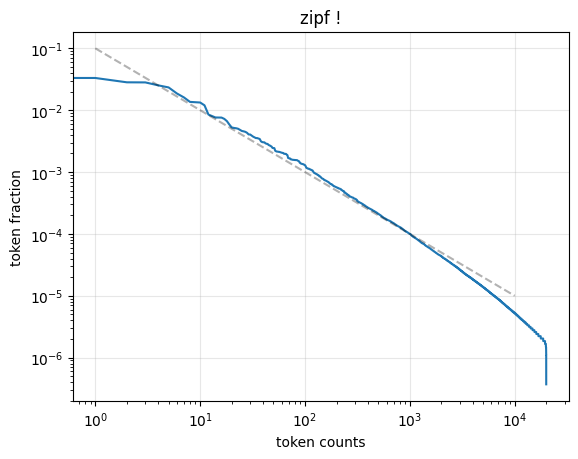

In [ ]:

# get fraction of total for each word
total_tokens = 0
for i,k in token_dict.items():
    total_tokens += k
total_tokens

token_usage = list()
for k in token_dict.values():
    token_usage.append((k/total_tokens))
token_usage = np.array(token_usage)
token_usage.sort()


plt.plot(token_usage[::-1]) # descending order
plt.yscale('log')
plt.ylabel('token fraction')
plt.xscale('log')
plt.xlabel('token counts')
plt.grid(alpha=0.3)
plt.plot([1,10000], [0.1,0.00001], c='k', ls='--',alpha=0.3)
plt.title('zipf !')

### Define model

In [17]:
def build_text_model():
  xin = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
  x0 = vectorize_layer(xin)
  x0 = tf.keras.layers.Embedding(vocab_length,
                                 embedding_dim,
                                 embeddings_regularizer=tf.keras.regularizers.l2(1e-4),)(x0)
  x0 = tf.keras.layers.Flatten()(x0)
  x0 = tf.keras.layers.Dropout(0.5)(x0)
  x0 = tf.keras.layers.Dense(64,activation='swish')(x0)
  xout = tf.keras.layers.Dense(1,activation='sigmoid')(x0)
  return tf.keras.models.Model(xin,xout)

scratch_model = build_text_model()

In [18]:
scratch_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 64)           1280000   
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dropout (Dropout)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 64)                2048064   
                                                             

In [19]:
scratch_model.compile(loss="binary_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                      metrics=["acc"])

In [20]:
''' train the thing '''
hist = scratch_model.fit(np.array(text_ds), # doesn't want to be a list !
                         label_ds,
                         validation_split=0.05,
                         epochs=20,
                         batch_size = 128)


Epoch 1/20
186/186 [==============================] - 30s 156ms/step - loss: 0.7733 - acc: 0.5333 - val_loss: 0.7504 - val_acc: 0.5440
Epoch 2/20
186/186 [==============================] - 30s 161ms/step - loss: 0.7045 - acc: 0.6527 - val_loss: 0.6502 - val_acc: 0.7200
Epoch 3/20
186/186 [==============================] - 27s 145ms/step - loss: 0.5359 - acc: 0.7920 - val_loss: 0.4732 - val_acc: 0.8200
Epoch 4/20
186/186 [==============================] - 28s 148ms/step - loss: 0.3881 - acc: 0.8670 - val_loss: 0.4061 - val_acc: 0.8384
Epoch 5/20
186/186 [==============================] - 27s 147ms/step - loss: 0.3184 - acc: 0.8973 - val_loss: 0.3725 - val_acc: 0.8544
Epoch 6/20
186/186 [==============================] - 28s 150ms/step - loss: 0.2730 - acc: 0.9201 - val_loss: 0.3517 - val_acc: 0.8672
Epoch 7/20
186/186 [==============================] - 27s 143ms/step - loss: 0.2410 - acc: 0.9312 - val_loss: 0.3369 - val_acc: 0.8744
Epoch 8/20
186/186 [==============================] - 2

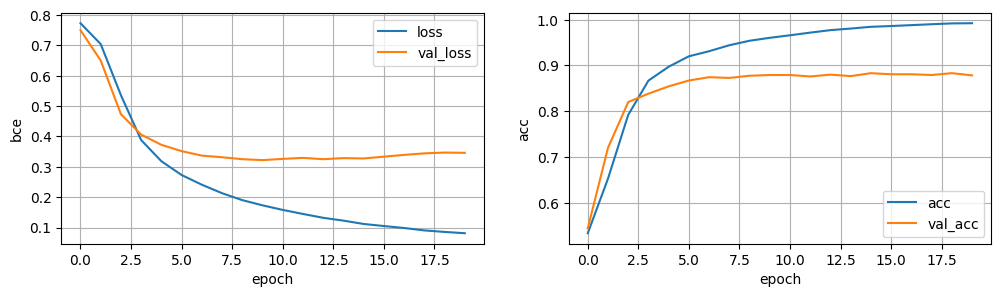

In [23]:
# look at curves

fig,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[1].plot(hist.history['acc'], label='acc')
ax[1].plot(hist.history['val_acc'], label='val_acc')
ax[0].set_ylabel('bce'); ax[1].set_ylabel('acc')
for i in range(2): ax[i].legend(); ax[i].grid(); ax[i].set_xlabel('epoch');

### model sanity check

In [22]:
sum(label_ds)

12500

In [25]:
scratch_model.predict([['i hated this crap movie. terrible, never see this garbage. great for date night if you hate the other person.'],
                       ['bad'],
                       ['great film. alan rickman was amaze-balls'],
                       [''],
                       ['not good']]) # what happens if the model gets no input (what is the bias?)

# it seems like the model has a hard time with short reviews, and maybe has a negative bias
# how can we check this correlation?


1/1 [==============================] - 0s 61ms/step


array([[0.07401192],
       [0.42659134],
       [0.60257983],
       [0.65226203],
       [0.666469  ]], dtype=float32)

### Evaluate model

In [ ]:
''' convert test dataset and make predictions '''

# extract test set from tfds class
test_text_ds = list()
for batch in tqdm(test_dataset):
    for i in batch['text']:
      test_text_ds.append(i.numpy())


# get test labels
test_label_ds = list()
for batch in tqdm(test_dataset):
    for i in batch['label']:
      test_label_ds.append(i.numpy())
test_label_ds = np.array(test_label_ds)

# use model to make prediction of test set
# ( the use of a list comprehension here is weird. each review needs to be it's own list, and this seems to work )
preds = scratch_model.predict([[x] for x in test_text_ds])


100%|██████████| 1563/1563 [00:08<00:00, 179.05it/s]


782/782 [==============================] - 10s 13ms/step


In [ ]:
''' post-process prediction '''
# take model outputs (which are sigmoid'ed) and round them to either 0 or 1
preds_quantized = np.round(preds).squeeze()

# check this works as expected
preds_quantized[:5]

array([1., 1., 0., 0., 1.], dtype=float32)

In [ ]:
''' evaluation metrics '''
# look at various evaluation metrics and look at AUC ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_label_ds, preds_quantized)

TP = cm[0][0] # true positive
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0] # false negative

evaluation = {'tpr': TP / (TP + FP),
              'fpr': TN / (TN + FN),
              'sensitivity': TP / (TP + FN),
              'specificity': TN / (TN + FP),
              'acc':(TP + TN) / (TP + TN + FP + FN),
              }

for i,k in evaluation.items():
    print(f'{i:>12} {round(k,3)}')



         tpr 0.885
         fpr 0.848
 sensitivity 0.853
 specificity 0.88
         acc 0.866


In [ ]:
auc = roc_auc_score(test_label_ds, preds.squeeze())
print('area under curve:',round(auc,3))

area under curve: 0.941


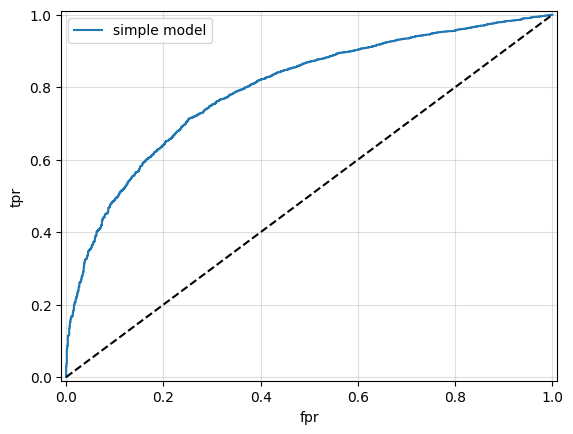

In [ ]:
''' ROC curve '''
# from: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# use just the predicted to be positive examples
mask = (preds > 0.5).squeeze()
preds_pos = preds[mask]

lr_fpr, lr_tpr, _ = roc_curve(test_label_ds[mask], preds_pos.squeeze()) # i have doubts about this (AUC > 0.9 but the curve looks like this??)

plt.plot(lr_fpr, lr_tpr, label='simple model')
plt.plot([0,1],[0,1],ls='--',c='k')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.grid(alpha=0.4)
plt.xlim(-0.01,1.01); plt.ylim(-0.01,1.01);

### Post-training inspection
We now have embeddings that we can compare. Let's find words that are similar

Text(0.5, 0, 'embedding (element index)')

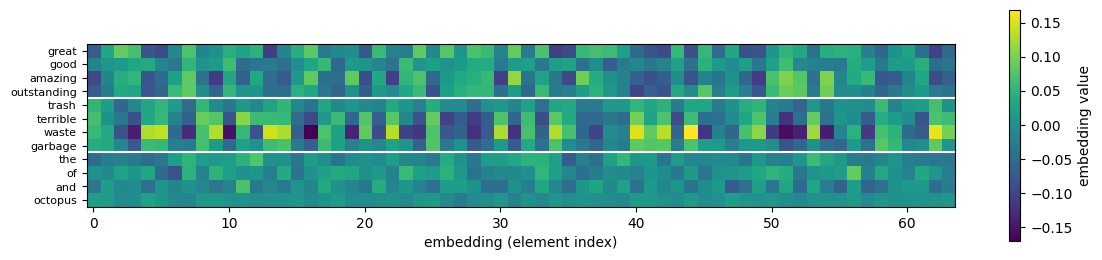

In [ ]:
''' compare embedding vector '''

query_words = ['great', 'good','amazing','outstanding', # positive words
               'trash','terrible','waste','garbage', # negative words
               'the','of','and','octopus'] # non-descript words

query_vector = np.zeros((len(query_words), embedding_dim))
for idx, _query_word in enumerate(query_words):
    # find the index for that word
    word_index = vectorize_layer.get_vocabulary().index(_query_word)
    # pull that word from the model
    query_vector[idx] = scratch_model.layers[2].get_weights()[0][word_index]

plt.figure(figsize=(14,3))
plt.imshow(query_vector)
plt.axhline(3.5,c='w')
plt.axhline(7.5,c='w')
plt.colorbar(label='embedding value')
plt.yticks(np.arange(12), query_words, fontsize=8);
plt.xlabel('embedding (element index)')

closest words to "bad":
   stinker
   ripoff
   dire
   fodder
   lackluster


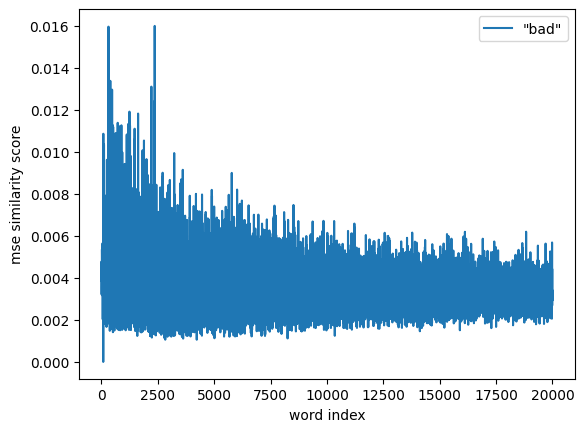

In [ ]:
''' find closest words '''

control_word = 'bad' # <<<< can modify this
control_vector = scratch_model.layers[2].get_weights()[0][vectorize_layer.get_vocabulary().index(control_word)]

from sklearn.metrics import mean_squared_error as mse
sim = list()
for word in scratch_model.layers[2].get_weights()[0]:
    sim.append(mse(control_vector, word))
sim = np.array(sim)

plt.plot(sim, label=f'"{control_word}"')
plt.legend()
plt.xlabel('word index')
plt.ylabel('mse similarity score') # mse may not work so well here

''' five most similar words '''
sorted_indices = sim.argsort()
print(f'closest words to "{control_word}":')
for i in range(1,6):
    print('  ',vectorize_layer.get_vocabulary()[sorted_indices[i]])


### Additional Resources

In [ ]:
''' references I found useful during this '''

# https://www.tensorflow.org/datasets/performances # how to best utilize datasets for large data or distributed training

# https://www.tensorflow.org/datasets/api_docs/python/tfds/load

# tfds.builder allows an inspection of the data without actually downloading it (all in prefetch?)
# how many samples, and shards


# https://www.tensorflow.org/datasets/overview#load_a_dataset
# primarily how to use the builder to look at metadata and dataset information
# [] does .load put the dataset in prefetch? yes


# primary source: https://keras.io/examples/nlp/text_classification_from_scratch/
# text vectorization layer and putting it into the model
# embedding layer
# [] regex
#
# and https://www.tensorflow.org/tutorials/keras/text_classification # uses vectorize BEFORE the model
# interesting exportation: vectorize layer in sequential model

# https://keras.io/examples/nlp/fnet_classification_with_keras_nlp/
# looks interesting, removes self-attention but does about as well as transformers (fourier based)
# uses more keras_nlp features


# https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html
# used to make sense of datasets

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# probably a useful reference of the available methods

# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
# universal scentence embedder from tf hub (model repo)

# https://developers.google.com/machine-learning/guides/text-classification/step-3
# great resource for intro to ML

# https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# cheating with bert (not even better)


# STOP WORDS
# stemmer